In [1]:
#正副總統投票率資料清洗
def vote_rate(filename,country):
    df = pd.read_excel(filename, sheet_name=country)
    colrebuild = '第15任總統副總統選舉候選人在' + country + '各村(里)得票數一覽表'
    df2 = df[[colrebuild, 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 12']]
    df3 = df2.rename({colrebuild: 'TOWNNAME', 'Unnamed: 1': 'VILLNAME', 'Unnamed: 2': '宋', 'Unnamed: 3': '韓','Unnamed: 4': '蔡', 'Unnamed: 5': '有效票數', 'Unnamed: 12': '投票率'}, axis=1)
    df4 = df3.drop([0, 1, 2, 3, 4])
    str_to_int_cols = ['宋', '韓', '蔡', '有效票數']
    for col in str_to_int_cols:
        df4[col] = df4[col].str.replace(',', '').astype(int)
    df4['COUNTYNAME'] = country
    df4 = df4.groupby(by = ['COUNTYNAME','TOWNNAME'], as_index = False).sum()
    df4['宋'] = df4['宋'] / df4['有效票數']
    df4['韓'] = df4['韓'] / df4['有效票數']
    df4['蔡'] = df4['蔡'] / df4['有效票數']
    return df4

In [2]:
import os
import re
import pandas as pd
os.chdir("C:\\Users\\caac1\\Desktop\\投票資訊\\總統-各投票所得票明細及概況(Excel檔)")
regex = re.compile(r'總統-A05-3-候選人得票數一覽表-各村里\((.+)\)')
count = 0
for filename in os.listdir(os.getcwd()):
    match = regex.search(filename)
    
    if match != None:
        df_each = vote_rate(filename, match.group(1))
        count = count + 1
        if count > 1:
            df = df.append(df_each)
        else:
            df = df_each
df=df.reset_index(drop = True)
df

,COUNTYNAME,TOWNNAME,宋,韓,蔡,有效票數
0,南投縣,中寮鄉,0.043976,0.417546,0.538479,9005
1,南投縣,仁愛鄉,0.034096,0.760716,0.205188,8212
2,南投縣,信義鄉,0.037816,0.619948,0.342236,8462
3,南投縣,南投市,0.050711,0.439870,0.509419,60677
4,南投縣,名間鄉,0.041537,0.354578,0.603885,23425
...,...,...,...,...,...,...
363,高雄市,阿蓮區,0.029219,0.278461,0.692320,18139
364,高雄市,鳥松區,0.032005,0.334282,0.633713,30214
365,高雄市,鳳山區,0.032010,0.361704,0.606286,227899
366,高雄市,鹽埕區,0.028173,0.326316,0.645511,16150


In [3]:
#地理資料清理
import geopandas as gpd
import pandas as pd
import shapely
os.chdir("C:\\Users\\caac1\\Desktop\\地圖")
gpd_map = gpd.read_file('VILLAGE_MOI_1081121.shp', encoding='utf-8')
#離群值處理:旗津區部分村里緯度20,導致圖片緯度差距大而台灣本島過小,因此將Index6032、6033刪除
gpd_map = gpd_map.drop(gpd_map.index[6032]).drop(gpd_map.index[6033])
gpd_map = gpd_map.reset_index(drop = True)
#縣市
county_map = gpd_map.groupby(by = ['COUNTYNAME'], as_index=False)
county_map = gpd.GeoDataFrame(
    county_map['geometry'].agg(lambda t:shapely.ops.unary_union(t))
)
#鄉鎮市區
town_map = gpd_map.groupby(by = ['COUNTYNAME','TOWNNAME'], as_index=False)
town_map = gpd.GeoDataFrame(
    town_map['geometry'].agg(lambda t:shapely.ops.unary_union(t))
)
town_map

,COUNTYNAME,TOWNNAME,geometry
0,南投縣,中寮鄉,"POLYGON ((120.77945 23.85107, 120.77939 23.851..."
1,南投縣,仁愛鄉,"POLYGON ((121.15414 23.86410, 121.15414 23.864..."
2,南投縣,信義鄉,"POLYGON ((120.88956 23.47565, 120.88922 23.475..."
3,南投縣,南投市,"POLYGON ((120.70712 23.89571, 120.70712 23.895..."
4,南投縣,名間鄉,"POLYGON ((120.72728 23.84548, 120.72728 23.845..."
...,...,...,...
363,高雄市,阿蓮區,"POLYGON ((120.31984 22.84155, 120.31983 22.841..."
364,高雄市,鳥松區,"POLYGON ((120.40042 22.64349, 120.40023 22.643..."
365,高雄市,鳳山區,"POLYGON ((120.35000 22.58551, 120.34997 22.585..."
366,高雄市,鹽埕區,"POLYGON ((120.29040 22.61886, 120.29041 22.618..."


In [4]:
#總統投票資料與地理資料合併
df['COUNTYNAME'] = df['COUNTYNAME'].str.strip()
df['TOWNNAME'] = df['TOWNNAME'].str.strip()
#縣市
county_map['COUNTYNAME'] = county_map['COUNTYNAME'].str.strip()
df_map_county = county_map.merge(df,left_on = ['COUNTYNAME'], right_on = ['COUNTYNAME'])
#鄉鎮市區
town_map['COUNTYNAME'] = town_map['COUNTYNAME'].str.strip()
town_map['TOWNNAME'] = town_map['TOWNNAME'].str.strip()
df_map_town = town_map.merge(df,left_on = ['COUNTYNAME','TOWNNAME'], right_on = ['COUNTYNAME','TOWNNAME'])
df_map_town

,COUNTYNAME,TOWNNAME,geometry,宋,韓,蔡,有效票數
0,南投縣,中寮鄉,"POLYGON ((120.77945 23.85107, 120.77939 23.851...",0.043976,0.417546,0.538479,9005
1,南投縣,仁愛鄉,"POLYGON ((121.15414 23.86410, 121.15414 23.864...",0.034096,0.760716,0.205188,8212
2,南投縣,信義鄉,"POLYGON ((120.88956 23.47565, 120.88922 23.475...",0.037816,0.619948,0.342236,8462
3,南投縣,南投市,"POLYGON ((120.70712 23.89571, 120.70712 23.895...",0.050711,0.439870,0.509419,60677
4,南投縣,名間鄉,"POLYGON ((120.72728 23.84548, 120.72728 23.845...",0.041537,0.354578,0.603885,23425
...,...,...,...,...,...,...,...
363,高雄市,阿蓮區,"POLYGON ((120.31984 22.84155, 120.31983 22.841...",0.029219,0.278461,0.692320,18139
364,高雄市,鳥松區,"POLYGON ((120.40042 22.64349, 120.40023 22.643...",0.032005,0.334282,0.633713,30214
365,高雄市,鳳山區,"POLYGON ((120.35000 22.58551, 120.34997 22.585...",0.032010,0.361704,0.606286,227899
366,高雄市,鹽埕區,"POLYGON ((120.29040 22.61886, 120.29041 22.618...",0.028173,0.326316,0.645511,16150


Populating the interactive namespace from numpy and matplotlib


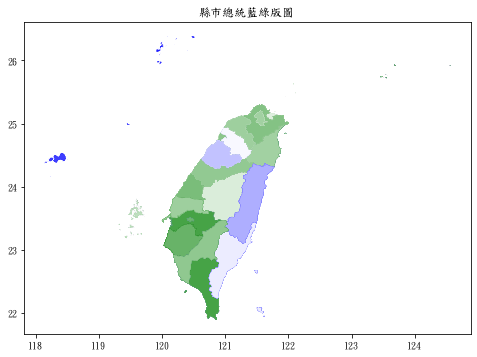

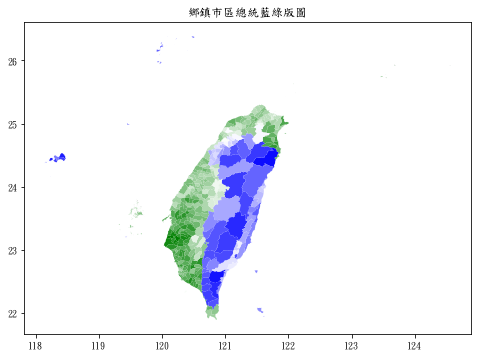

In [5]:
#繪製縣市與鄉鎮市區總統投票概況圖,蔡英文得票率由高到低顏色對應為綠->白->藍
%pylab inline
from  matplotlib.colors import LinearSegmentedColormap
pylab.rcParams['figure.figsize'] = (8,8)
bwg = LinearSegmentedColormap.from_list('rg', ["b", "w", "g"])

df_map_county.plot(column = '蔡', cmap = bwg)
plt.title('縣市總統藍綠版圖')
df_map_town.plot(column = '蔡',cmap = bwg)
plt.title('鄉鎮市區總統藍綠版圖')
plt.show()

In [6]:
#蔡英文高票區、韓國瑜、蔡與韓相當區前10名鄉鎮市區表格彙整
df_town_tsai_top = df_map_town.sort_values(by = '蔡', ascending = False).head(10).reset_index(drop=True)
df_town_han_top = df_map_town.sort_values(by = '韓', ascending = False).head(10).reset_index(drop=True)
df_map_town['英韓差距'] = (df_map_town['蔡'] - df_map_town['韓']).abs()
df_town_neutral_top =  df_map_town.sort_values(by = '英韓差距', ascending = True).head(10).reset_index(drop=True)
df_most = pd.DataFrame(columns = None)
df_most['蔡英文高票區'] = df_town_tsai_top['COUNTYNAME'].str.cat(df_town_tsai_top['TOWNNAME'], sep=" ")
df_most['韓國瑜高票區'] = df_town_han_top['COUNTYNAME'].str.cat(df_town_han_top['TOWNNAME'], sep=" ")
df_most['蔡與韓相當區'] = df_town_neutral_top['COUNTYNAME'].str.cat(df_town_neutral_top['TOWNNAME'], sep=" ")
df_most

,蔡英文高票區,韓國瑜高票區,蔡與韓相當區
0,臺南市 將軍區,金門縣 烏坵鄉,基隆市 信義區
1,臺南市 麻豆區,宜蘭縣 南澳鄉,臺南市 楠西區
2,臺南市 西港區,臺東縣 金峰鄉,南投縣 埔里鎮
3,臺南市 學甲區,連江縣 莒光鄉,高雄市 甲仙區
4,臺南市 七股區,金門縣 金沙鎮,桃園市 龍潭區
5,臺南市 官田區,金門縣 烈嶼鄉,臺北市 大安區
6,屏東縣 九如鄉,連江縣 北竿鄉,南投縣 國姓鄉
7,臺南市 安定區,花蓮縣 卓溪鄉,南投縣 水里鄉
8,臺南市 六甲區,臺東縣 達仁鄉,臺北市 文山區
9,屏東縣 新園鄉,連江縣 南竿鄉,南投縣 鹿谷鄉
